In [2]:
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Sequential,save_model,load_model
from tensorflow.keras.optimizers import Adam

import time
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt

In [15]:
class ReplayBuffer():
    def __init__(self, max_size, input_dims):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = 1 - int(done)
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]
        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
        Dense(fc1_dims, activation='relu'),
        Dense(fc2_dims, activation='relu'),
        Dense(n_actions, activation=None)])
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model

class Agent():
    def __init__(self, lr, gamma, n_actions, epsilon, batch_size,
                input_dims, epsilon_dec=1e-3, epsilon_end=0.01,
                mem_size=1000000, fname='dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = epsilon_dec
        self.eps_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.buffer = ReplayBuffer(mem_size, input_dims)
        self.q_model = build_dqn(lr, n_actions, input_dims, 256, 256)

    def store_transition(self, state, action, reward, new_state, done):
        self.buffer.store_transition(state, action, reward, new_state, done)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation])
            actions = self.q_model.predict(state)
            action = np.argmax(actions)
        return action

    def learn(self):
        if self.buffer.mem_cntr < self.batch_size:
            return
        states, actions, rewards, states_, dones = self.buffer.sample_buffer(self.batch_size)
        q_eval = self.q_model.predict(states)
        q_next = self.q_model.predict(states_)
        q_target = np.copy(q_eval)
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        q_target[batch_index, actions] = rewards + self.gamma * np.max(q_next, axis=1)*dones
        self.q_model.train_on_batch(states, q_target) #this is the model fit - on only one batch 
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def save_model(self):
        self.q_model.save(self.model_file)


    def load_model(self):
        self.q_model = load_model(self.model_file)


---------- Running ! ----------

game: 50 last 50 average score -43.08 epsilon 0.01 at 17:38:40 after 20314 loops
game: 100 last 50 average score 61.30 epsilon 0.01 at 17:40:38 after 40935 loops
game: 150 last 50 average score 182.74 epsilon 0.01 at 17:42:33 after 59965 loops
game: 200 last 50 average score 183.31 epsilon 0.01 at 17:44:02 after 74863 loops
game: 250 last 50 average score 197.02 epsilon 0.01 at 17:45:42 after 91755 loops
game: 300 last 50 average score 173.30 epsilon 0.01 at 17:47:01 after 105144 loops
game: 350 last 50 average score 197.97 epsilon 0.01 at 17:48:29 after 119828 loops
game: 400 last 50 average score 209.49 epsilon 0.01 at 17:49:56 after 134485 loops
game: 450 last 50 average score 166.63 epsilon 0.01 at 17:51:08 after 146700 loops
game: 500 last 50 average score 158.96 epsilon 0.01 at 17:52:27 after 160160 loops

---------- Finished ! ----------

Buffer contains 160160 rows


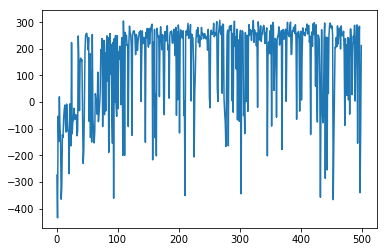

In [18]:
tf.compat.v1.disable_eager_execution()

env = gym.make('LunarLander-v2')
lr = 0.001
n_games = 500
report_every = 50
filename = 'dqn_model_Latest.h5'

agent = Agent(gamma=0.99,
              epsilon=1.0, 
              lr=lr, 
              input_dims=env.observation_space.shape,
              n_actions=env.action_space.n, 
              mem_size=1000000, 
              batch_size=64,
              epsilon_end=0.01,
              fname=filename)
scores = []
eps_history = []
num_loops =0 

print("\n---------- Running ! ----------\n")   
for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        observation = observation_
        agent.learn()
        num_loops +=1
    eps_history.append(agent.epsilon)
    scores.append(score)
    if (i+1) % report_every ==0 :
        avg_score = np.mean(scores[-report_every:])
        print('game: {} last {} average score {:.2f} epsilon {:.2f} at {} after {} loops'.format(i+1,report_every,avg_score, agent.epsilon,time.strftime('%X'),num_loops))

print("\n---------- Finished ! ----------\n")   
print("Buffer contains {} rows".format(agent.buffer.mem_cntr))
agent.save_model()

fig = plt.figure()
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(scores ,label='Score')

In [19]:
# lunar lander demo with trained model
env = gym.make('LunarLander-v2')
observation = env.reset()
done = False

while not done:
    env.render()
    action = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    score += reward
    agent.store_transition(observation, action, reward, observation_, done)
    observation = observation_
print(observation_, reward, done, info,action)
env.close()

[-8.2423307e-02 -1.1038089e-03 -4.9280543e-03 -6.4112969e-06
 -1.1305586e-03  2.8946808e-06  1.0000000e+00  1.0000000e+00] 1.3141106294474316 True {'TimeLimit.truncated': True} 3


In [ ]:
# lunar lander demo with trained model but no Q table

import gym
env = gym.make('LunarLander-v2')
observation = env.reset()
done = False

agent_loaded =  Agent(gamma=0.99, epsilon=1.0, lr=lr, 
                input_dims=env.observation_space.shape,
                n_actions=env.action_space.n, mem_size=1000000, batch_size=64,
                epsilon_end=0.01,fname='dqn_model_Latest.h5')
agent_loaded.load_model()

while not done:
    env.render()
    action = agent_loaded.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    score += reward
    agent_loaded.store_transition(observation, action, reward, observation_, done)
    observation = observation_
    
env.close()

In [ ]:
# lunar lander demo with random actions

import gym

env = gym.make('LunarLander-v2')
env.reset()

for _ in range(1000):
    env.render()
    env.step(env.action_space.sample())
    
env.close()

26601
